In [1]:
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import lightgbm as lgb
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer
from scipy.stats import boxcox
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import RFECV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import QuantileTransformer
import optuna
import json

# Set style
plt.style.use('ggplot')
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")


In [ ]:
class BikeDemandDataProcessor:
    def __init__(self, path):
        self.path = path

    def load_data(self, filename):
        full_path = f"{self.path}/{filename}"
        print(f"Loading data from {full_path}")
        try:
            return pd.read_csv(full_path)
        except FileNotFoundError:
            print(f"File {filename} not found in path {self.path}.")
            return None

    def preprocess(self, df):

        df = df.copy()

        # Creating timestamp column
        df['timestamp'] = pd.to_datetime(df['dteday'] + ' ' + df['hr'].astype(str) + ':00:00', format='%d/%m/%Y %H:%M:%S')

        # Renaming columns
        df = df.rename(columns={'hr': 'hour', 'yr' : 'year', 'mnth' : 'month', 'cnt' : 'count'})
        df = df.drop(['dteday', 'instant'], axis=1)
        
        # Time features
        df['year'] = df['timestamp'].dt.year
        df['day'] = df['timestamp'].dt.day_of_year
        df['day_of_week'] = df['timestamp'].dt.day_of_week
        df['day_of_month'] = df['timestamp'].dt.day
        df['month'] = df['timestamp'].dt.month
        df['week'] = df['timestamp'].dt.isocalendar().week
        
        # Cyclic encoding
        df['year_sin'] = np.sin(2 * np.pi * df['year'])
        df['year_cos'] = np.cos(2 * np.pi * df['year'])
        df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12) 
        df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
        df['day_sin'] = np.sin(2 * np.pi * df['day'] / 31)  
        df['day_cos'] = np.cos(2 * np.pi * df['day'] / 31)
        df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
        df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
        df['week_sin'] = np.sin(2 * np.pi * df['week'] / 52)
        df['week_cos'] = np.cos(2 * np.pi * df['week'] / 52)
        
        # Day type features
        df['working_day'] = df['day_of_week'].apply(lambda x: 1 if x < 5 else 0)
        df['weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
        df['is_monday'] = (df['day_of_week'] == 0).astype(int)
        df['is_friday'] = (df['day_of_week'] == 4).astype(int)
        
        # Special periods
        df['moonphase'] = df['timestamp'].apply(lambda x: (x.day + x.month * 29.53) % 29.53)
        df['quarter'] = df['timestamp'].dt.quarter
        df['christmas_holiday_season'] = df['timestamp'].apply(lambda x: 1 if (x.month == 1 and x.day <= 14) or (x.month == 12 and x.day >= 24) else 0)
        df['summer_season'] = df['timestamp'].apply(lambda x: 1 if 6 <= x.month <= 8 else 0)
        df['spring_season'] = df['timestamp'].apply(lambda x: 1 if 3 <= x.month <= 5 else 0)
        df['fall_season'] = df['timestamp'].apply(lambda x: 1 if 9 <= x.month <= 11 else 0)
        df['winter_season'] = df['timestamp'].apply(lambda x: 1 if x.month in [12, 1, 2] else 0)
        df['day_of_year'] = df['timestamp'].dt.dayofyear
        
        # Hour features (rush hour made estimated form visualisations)
        df['is_business_hours'] = ((df['hour'] >= 8) & (df['hour'] <= 18) & (df['working_day'] == 1)).astype(int)
        df['is_night'] = ((df['hour'] >= 22) | (df['hour'] <= 6)).astype(int)
        df['rush_hour'] = df.apply(lambda x: 1 if ((x['hour'] >= 4 and x['hour'] <= 10) or (x['hour'] >= 15 and x['hour'] <= 21)) and x['working_day'] == 1 else 0, axis=1)

        # Creating interaction features
        df['hum_windspeed'] = df['hum'] * df['windspeed']
        df['temp_hum'] = df['temp'] * df['hum']
        df['temp_windspeed'] = df['temp'] * df['windspeed']
        df['windspeed_squared'] = df['windspeed'] ** 2
        df['hum_squared'] = df['hum'] ** 2
        
        # Weather interaction features
        df['weather_temp'] = df['weathersit'] * df['temp']
        df['weather_hum'] = df['weathersit'] * df['hum']
        df['weather_windspeed'] = df['weathersit'] * df['windspeed']
        
        # Atemp interaction features
        df['atemp_hum'] = df['atemp'] * df['hum']
        df['atemp_windspeed'] = df['atemp'] * df['windspeed']
        df['atemp_squared'] = df['atemp'] ** 2
        df['temp_atemp'] = df['temp'] * df['atemp']
        df['weather_atemp'] = df['weathersit'] * df['atemp']
        
        # Temperature difference feature
        df['temp_atemp_diff'] = np.abs(df['temp'] - df['atemp'])

        # Convert object columns to category
        for col in df.select_dtypes(include='object').columns:
            df[col] = df[col].astype('category')

        return df.drop_duplicates()
    
    def feature_engineering(self, train_df, val_df):
        train_df = train_df.copy()
        val_df = val_df.copy()

        # Avoid division by zero
        casual_sum = train_df['casual'].sum()
        if casual_sum == 0:
            casual_sum = 1  # Prevent division by zero

        total_ratio_of_registered_uses = train_df['registered'].sum() / casual_sum

        # Average ratios for different time-based groupings
        average_hour_ratio = train_df.groupby('hour').agg(
            ratio=('registered', lambda x: x.sum() / max(x.sum(), 1))
        )['ratio']

        average_day_ratio = train_df.groupby('day_of_week').agg(
            ratio=('registered', lambda x: x.sum() / max(x.sum(), 1))
        )['ratio']

        average_week_ratio = train_df.groupby('week').agg(
            ratio=('registered', lambda x: x.sum() / max(x.sum(), 1))
        )['ratio']

        average_month_ratio = train_df.groupby('month').agg(
            ratio=('registered', lambda x: x.sum() / max(x.sum(), 1))
        )['ratio']

        average_season_ratio = train_df.groupby('season').agg(
            ratio=('registered', lambda x: x.sum() / max(x.sum(), 1))
        )['ratio']

        average_weekend_ratio = train_df.groupby('weekend').agg(
            ratio=('registered', lambda x: x.sum() / max(x.sum(), 1))
        )['ratio']

        average_working_day_ratio = train_df.groupby('working_day').agg(
            ratio=('registered', lambda x: x.sum() / max(x.sum(), 1))
        )['ratio']



        # Applying ratios to both train and validation sets
        train_df['total_registered_ratio'] = total_ratio_of_registered_uses
        val_df['total_registered_ratio'] = total_ratio_of_registered_uses

        train_df['hour_ratio'] = train_df['hour'].map(average_hour_ratio)
        val_df['hour_ratio'] = val_df['hour'].map(average_hour_ratio)

        train_df['day_ratio'] = train_df['day_of_week'].map(average_day_ratio)
        val_df['day_ratio'] = val_df['day_of_week'].map(average_day_ratio)

        # Mapping working day and weekend registered ratios (could go further and do this for each motnh, week, etc.)
        train_df['working_day_or_weekend_ratio'] = train_df['working_day'].map(average_working_day_ratio).where(train_df['working_day'] == 1, 
                                                                                                                        train_df['weekend'].map(average_weekend_ratio))
        val_df['working_day_or_weekend_ratio'] = val_df['working_day'].map(average_working_day_ratio).where(val_df['working_day'] == 1, 
                                                                                                                    val_df['weekend'].map(average_weekend_ratio))

        train_df['week_ratio'] = train_df['week'].map(average_week_ratio)
        val_df['week_ratio'] = val_df['week'].map(average_week_ratio)

        train_df['month_ratio'] = train_df['month'].map(average_month_ratio)
        val_df['month_ratio'] = val_df['month'].map(average_month_ratio)

        train_df['season_ratio'] = train_df['season'].map(average_season_ratio)
        val_df['season_ratio'] = val_df['season'].map(average_season_ratio)

        # Dropping columns that won't be available for prediction
        train_df = train_df.drop(['casual', 'registered'], axis=1)
        val_df = val_df.drop(['casual', 'registered'], axis=1)

        ## An idea to try and project outliers into the future as I saw some seemed to be repeated so maybe a notable event of som sort
        # Aggregate counts to daily level
        daily_train_df = train_df.groupby(['year', 'month', 'day', 'day_of_year'])[['count']].sum().reset_index()

        # Calculate rolling mean and standard deviation (2-week window)
        rolling_mean = daily_train_df['count'].rolling(window=14, center=True).mean()
        rolling_std = daily_train_df['count'].rolling(window=14, center=True).std()

        # Identify 3-sigma outliers
        daily_train_df['sigma_3_outlier'] = (daily_train_df['count'] > rolling_mean + 3 * rolling_std) | \
                                            (daily_train_df['count'] < rolling_mean - 3 * rolling_std)

        # Find max outlier flag per day_of_year
        day_of_year_outlier = daily_train_df.groupby('day_of_year', as_index=False)['sigma_3_outlier'].max()

        # Merge back into train_df and val_df
        train_df = train_df.merge(day_of_year_outlier, on='day_of_year', how='left')
        val_df = val_df.merge(day_of_year_outlier, on='day_of_year', how='left')

        # Fill NaN values (if no outlier was detected for that day, assume False)
        train_df['sigma_3_outlier'] = train_df['sigma_3_outlier'].fillna(0)
        val_df['sigma_3_outlier'] = val_df['sigma_3_outlier'].fillna(0)

        return train_df.drop_duplicates(), val_df.drop_duplicates()
            
    def split_and_engineer_data(self, df):
        sorted_df = df.sort_values('timestamp').copy()
        sorted_df = sorted_df.drop('timestamp', axis=1)

        original_shape = sorted_df.drop(['casual', 'registered'], axis = 1).shape  # Store original shape

        train_df, val_df = train_test_split(sorted_df, test_size=0.2, shuffle=False)

        train_df, val_df = self.feature_engineering(train_df, val_df)

        # Ensure row count is unchanged when reducing back to original columns
        original_columns = sorted_df.drop(['casual', 'registered'], axis = 1).columns.tolist()
        
        reduced_train = train_df[original_columns]
        reduced_val = val_df[original_columns]

        combined_df = pd.concat([reduced_train, reduced_val])

        assert combined_df.shape == original_shape, "Row count mismatch after feature engineering!"

        return train_df, val_df


In [3]:
parent_path = Path().resolve()
processor = BikeDemandDataProcessor(parent_path)
hour_raw_df = processor.load_data("data/hour.csv")
hour_processed_df = processor.preprocess(hour_raw_df)

Loading data from C:\Users\Lawrence\Documents\PYTHON\bike_demand_2025/data/hour.csv


In [4]:
test_period = 14*24  # 14 days of hourly data

test_df = hour_processed_df[-test_period:]
test_df.to_csv("data/processed_data/test.csv", index=False)
train_df, val_df = processor.split_and_engineer_data(hour_processed_df[:-test_period])

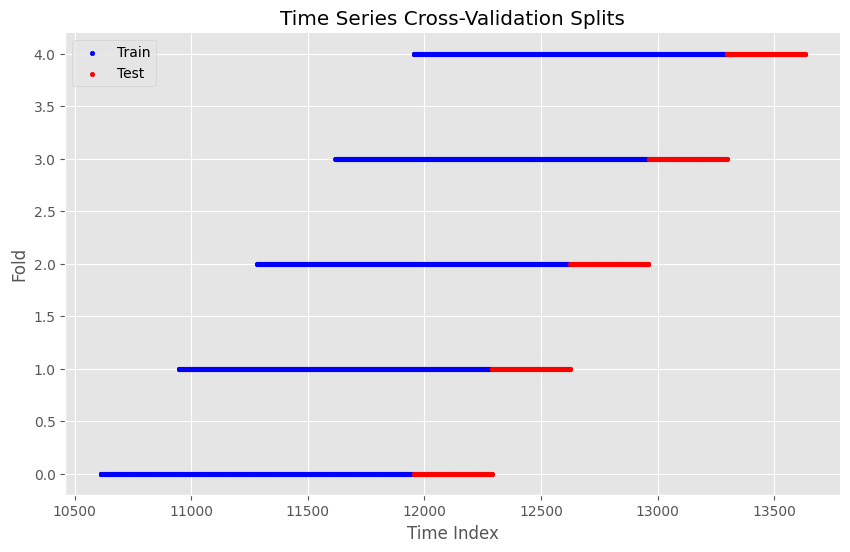

In [5]:
n_samples = len(train_df)

tcsv = TimeSeriesSplit(
    n_splits=5,
    max_train_size=int(24 * 14 / 0.2 * 0.8),
    test_size=int(24 * 14),
)

fig, ax = plt.subplots(figsize=(10, 6))

for i, (train_idx, test_idx) in enumerate(tcsv.split(np.arange(n_samples))):
    ax.scatter(train_idx, [i] * len(train_idx), color="blue", label="Train" if i == 0 else "", s=10)
    ax.scatter(test_idx, [i] * len(test_idx), color="red", label="Test" if i == 0 else "", s=10)

ax.set_xlabel("Time Index")
ax.set_ylabel("Fold")
ax.set_title("Time Series Cross-Validation Splits")
ax.legend()
sns.despine()
plt.show()

In [6]:
lambda_ = None  # Store lambda globally

def func(x):
    global lambda_
    x = np.ravel(x)
    transformed, lambda_ = boxcox(x + 1)
    return transformed.reshape(-1, 1)

def inverse_func(x):
    global lambda_
    x = np.ravel(x)
    if lambda_ is None:
        raise ValueError("Lambda is not set. Call func() first.")
    if lambda_ == 0:
        return (np.exp(x) - 1).reshape(-1, 1)
    else:
        return ((x * lambda_ + 1) ** (1 / lambda_) - 1).reshape(-1, 1)


features_from_rfe_selection = ['year', 'hour', 'weekday', 'workingday', 'temp', 'day', 'day_of_week', 'day_cos', 'hour_sin', 'hum_windspeed', 'temp_hum', 'weather_hum', 'temp_atemp', 'weather_atemp', 'hour_ratio']

target = 'count'

numeric_columns = [ 'temp', 'day_cos', 'hour_sin', 'hum_windspeed', 'temp_hum', 'weather_hum', 'temp_atemp', 'weather_atemp', 'hour_ratio']

categorical_label_encode_columns = ['year', 'hour', 'day', 'day_of_week']
categorical_one_hot_columns = ['weekday', 'workingday']

features = features_from_rfe_selection

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", RobustScaler())
])

categorical_onehot_transformer = Pipeline([
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

categorical_label_transformer = Pipeline([
    ("encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_columns),
        ("cat_label", categorical_label_transformer, categorical_label_encode_columns)
    ],
    remainder='drop',
    n_jobs=-1
)

X_train = train_df[features]
y_train = train_df[target]


In [7]:
def objective(trial):

    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'random_state': 42,
        'verbose': -1
    }

    hour_processed_train_size_df = hour_processed_df.sort_values('timestamp').iloc[:int(len(hour_processed_df) * 0.8)]

    rmse_of_folds_list = []

    for train_idx, test_idx in tcsv.split(np.arange(len(hour_processed_train_size_df))):

        full_idx = np.concatenate((train_idx, test_idx))

        fold_df = hour_processed_train_size_df.iloc[full_idx]

        train_split, val_split = processor.split_and_engineer_data(fold_df)

        y_train_split = train_split['count']
        X_train_split = train_split[features_from_rfe_selection]

        y_val_split = val_split['count']
        X_val_split = val_split[features_from_rfe_selection]

        # Create the LGBM regressor with early stopping
        lgbm_regressor = lgb.LGBMRegressor(**params)

        # Create the transformed target regressor
        transformed_regressor = TransformedTargetRegressor(
            regressor=lgbm_regressor,
            func=func,
            inverse_func=inverse_func
        )

        # Create the full pipeline
        pipe = Pipeline([
            ('preprocessor', preprocessor),
            ('model', transformed_regressor)
        ])

        # Fit the model
        pipe.fit(X_train_split, y_train_split)

        # Predict the validation set
        y_pred = pipe.predict(X_val_split)

        # Calculate the RMSE
        rmse_value = np.sqrt(mean_squared_error(y_val_split, y_pred))

        rmse_of_folds_list.append(rmse_value)

    return np.mean(rmse_of_folds_list)

study = optuna.create_study(direction='minimize')

n_trials = 500
study.optimize(objective, n_trials=n_trials)

with open('best_lgbm_params.json', 'w') as f:
    json.dump(study.best_params, f, indent=4)

print(f"Best parameters: {study.best_params}")
print(f"Best RMSE: {study.best_value}")


[I 2025-03-10 21:17:12,028] A new study created in memory with name: no-name-251d97ea-b0d5-4054-9aef-e5ec8cc26e45
c:\Users\Lawrence\Documents\PYTHON\bike_demand_2025\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\Lawrence\Documents\PYTHON\bike_demand_2025\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\Lawrence\Documents\PYTHON\bike_demand_2025\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\Lawrence\Documents\PYTHON\bike_demand_2025\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warni

Best parameters: {'n_estimators': 191, 'learning_rate': 0.047608610881061546, 'max_depth': 15, 'num_leaves': 38, 'min_child_samples': 15, 'subsample': 0.5871825601318645, 'colsample_bytree': 0.9993566609700696, 'reg_alpha': 0.5932704933313724, 'reg_lambda': 0.6066851210991239}
Best RMSE: 69.849984675694


c:\Users\Lawrence\Documents\PYTHON\bike_demand_2025\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\Lawrence\Documents\PYTHON\bike_demand_2025\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\Lawrence\Documents\PYTHON\bike_demand_2025\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\Lawrence\Documents\PYTHON\bike_demand_2025\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\Lawrence\Documents\PYTHON\bike_demand_2025\venv\Lib\site-packages\sklearn\utils\validation.py:2

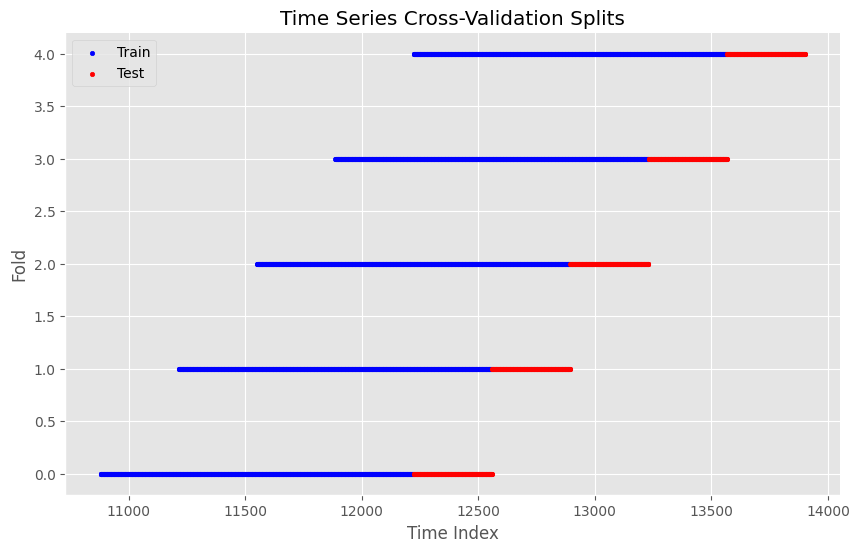

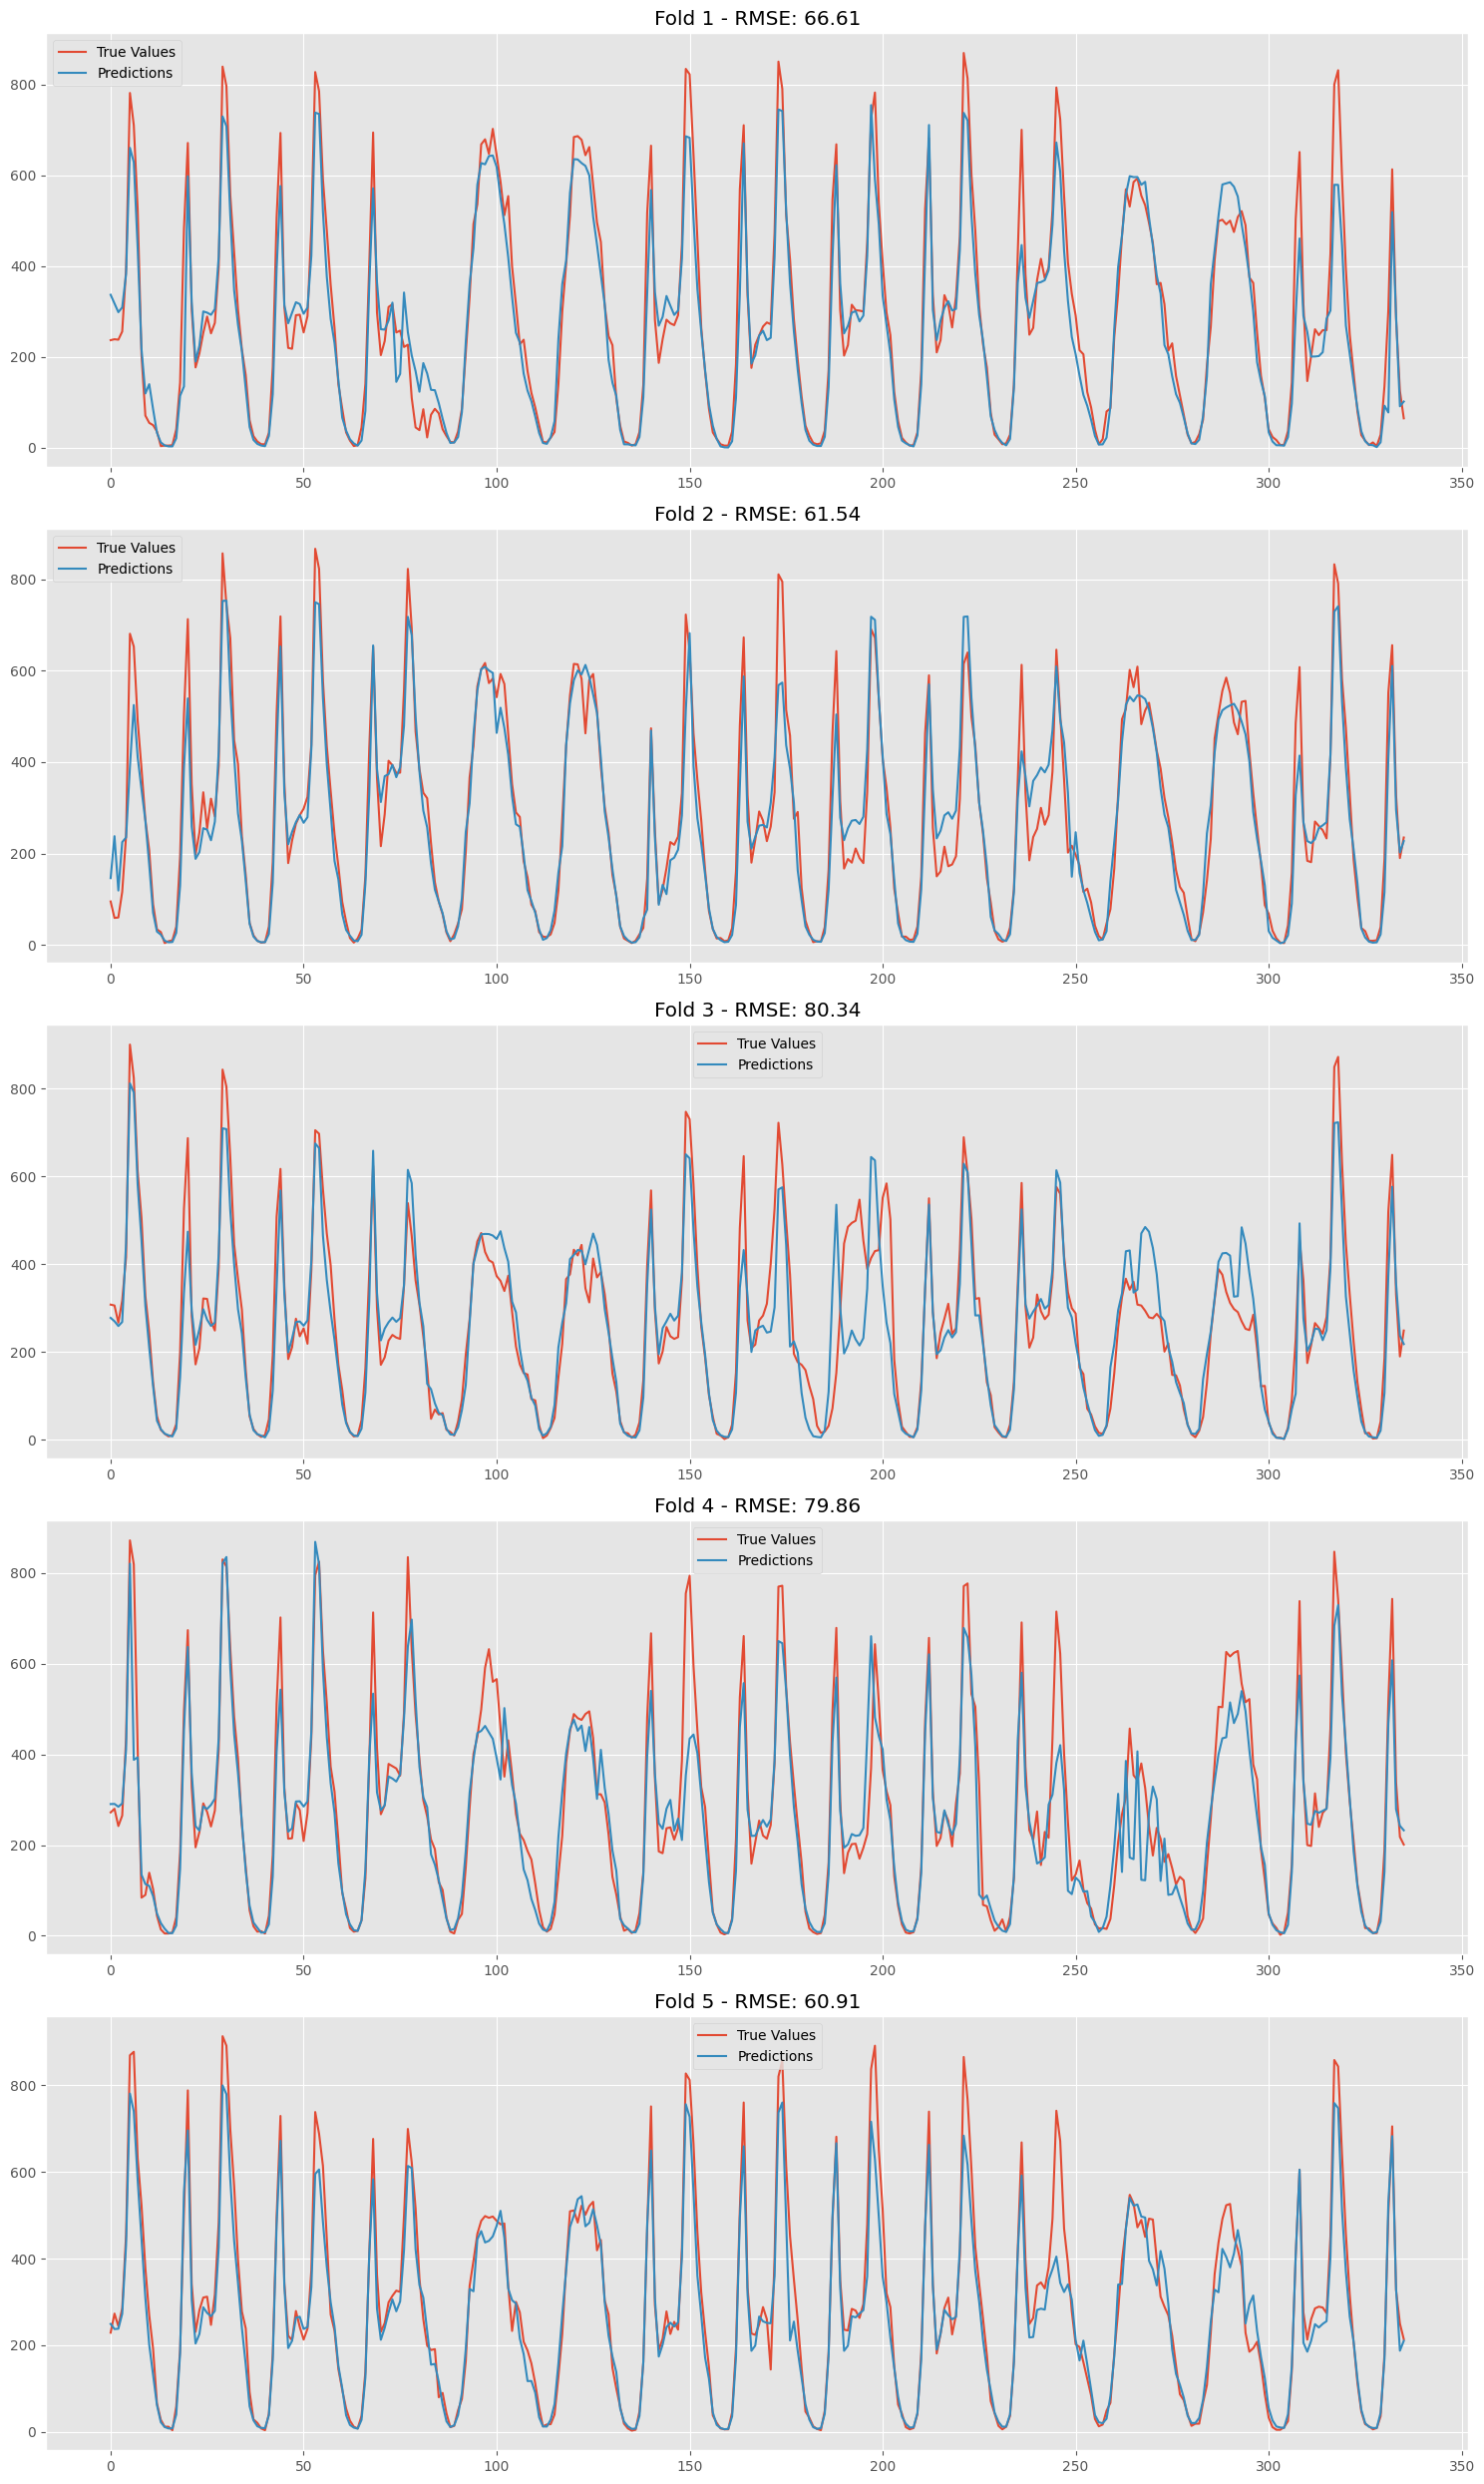

Average RMSE across folds: 69.85


In [8]:
best_params = study.best_params

hour_processed_train_size_df = hour_processed_df.sort_values('timestamp').iloc[:int(len(hour_processed_df) * 0.8)]

rmse_of_folds_list = []
fold_predictions = []
fold_true_values = []

fig, ax = plt.subplots(figsize=(10, 6))

for i, (train_idx, test_idx) in enumerate(tcsv.split(np.arange(len(hour_processed_train_size_df)))):
    ax.scatter(train_idx, [i] * len(train_idx), color="blue", label="Train" if i == 0 else "", s=10)
    ax.scatter(test_idx, [i] * len(test_idx), color="red", label="Test" if i == 0 else "", s=10)

    full_idx = np.concatenate((train_idx, test_idx))

    fold_df = hour_processed_train_size_df.iloc[full_idx]

    train_split, val_split = processor.split_and_engineer_data(fold_df)

    y_train_split = train_split['count']
    X_train_split = train_split[features_from_rfe_selection]

    y_val_split = val_split['count']
    X_val_split = val_split[features_from_rfe_selection]

    # Create the LGBM regressor with the best parameters
    lgbm_regressor = lgb.LGBMRegressor(**best_params, verbose=-1)

    # Create the transformed target regressor
    transformed_regressor = TransformedTargetRegressor(
        regressor=lgbm_regressor,
        func=func,
        inverse_func=inverse_func
    )

    # Create the full pipeline
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('model', transformed_regressor)
    ])

    # Fit the model
    pipe.fit(X_train_split, y_train_split)

    # Predict the validation set
    y_pred = pipe.predict(X_val_split)

    # Store predictions and true values for plotting
    fold_predictions.append(y_pred)
    fold_true_values.append(y_val_split.values)

    # Calculate the RMSE
    rmse = np.sqrt(mean_squared_error(y_val_split, y_pred))

    rmse_of_folds_list.append(rmse)

ax.set_xlabel("Time Index")
ax.set_ylabel("Fold")
ax.set_title("Time Series Cross-Validation Splits")
ax.legend()
sns.despine()
plt.show()

# Plot the results for each fold
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(15, 25))

for i, (y_pred, y_true) in enumerate(zip(fold_predictions, fold_true_values)):
    axes[i].plot(y_true, label='True Values')
    axes[i].plot(y_pred, label='Predictions')
    axes[i].set_title(f'Fold {i+1} - RMSE: {rmse_of_folds_list[i]:.2f}')
    axes[i].legend()

plt.tight_layout()
plt.show()

print(f"Average RMSE across folds: {np.mean(rmse_of_folds_list):.2f}")


Validation RMSE: 65.86845807556932


c:\Users\Lawrence\Documents\PYTHON\bike_demand_2025\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\Lawrence\AppData\Local\Temp\ipykernel_41268\2257259008.py:26: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


<Figure size 1000x600 with 0 Axes>

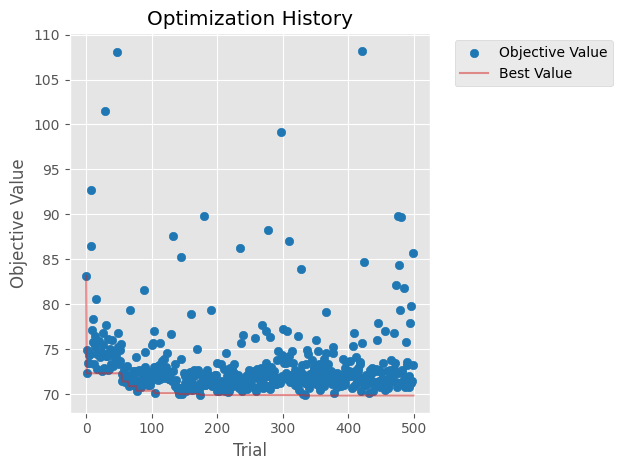

C:\Users\Lawrence\AppData\Local\Temp\ipykernel_41268\2257259008.py:32: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)


<Figure size 1000x600 with 0 Axes>

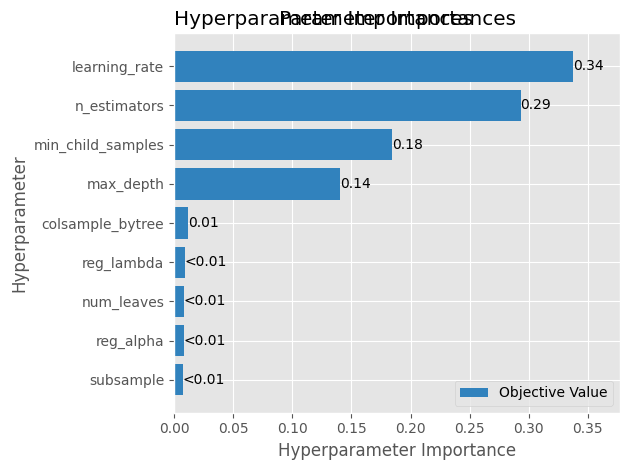

In [9]:
best_params = study.best_params
best_lgbm = lgb.LGBMRegressor(**best_params)

best_regr = TransformedTargetRegressor(
    regressor=best_lgbm,
    func=func,
    inverse_func=inverse_func
)

best_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', best_regr)
])

best_pipeline.fit(X_train, y_train)

val_X = val_df[features]
val_y = val_df[target]

val_predictions = best_pipeline.predict(val_X)
val_rmse = np.sqrt(mean_squared_error(val_y, val_predictions))

print(f"Validation RMSE: {val_rmse}")

plt.figure(figsize=(10, 6))
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.title("Optimization History")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
optuna.visualization.matplotlib.plot_param_importances(study)
plt.title("Parameter Importances")
plt.tight_layout()
plt.show()

C:\Users\Lawrence\AppData\Local\Temp\ipykernel_41268\2375574420.py:1: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_slice(study)


array([<Axes: xlabel='colsample_bytree', ylabel='Objective Value'>,
       <Axes: xlabel='learning_rate'>, <Axes: xlabel='max_depth'>,
       <Axes: xlabel='min_child_samples'>, <Axes: xlabel='n_estimators'>,
       <Axes: xlabel='num_leaves'>, <Axes: xlabel='reg_alpha'>,
       <Axes: xlabel='reg_lambda'>, <Axes: xlabel='subsample'>],
      dtype=object)

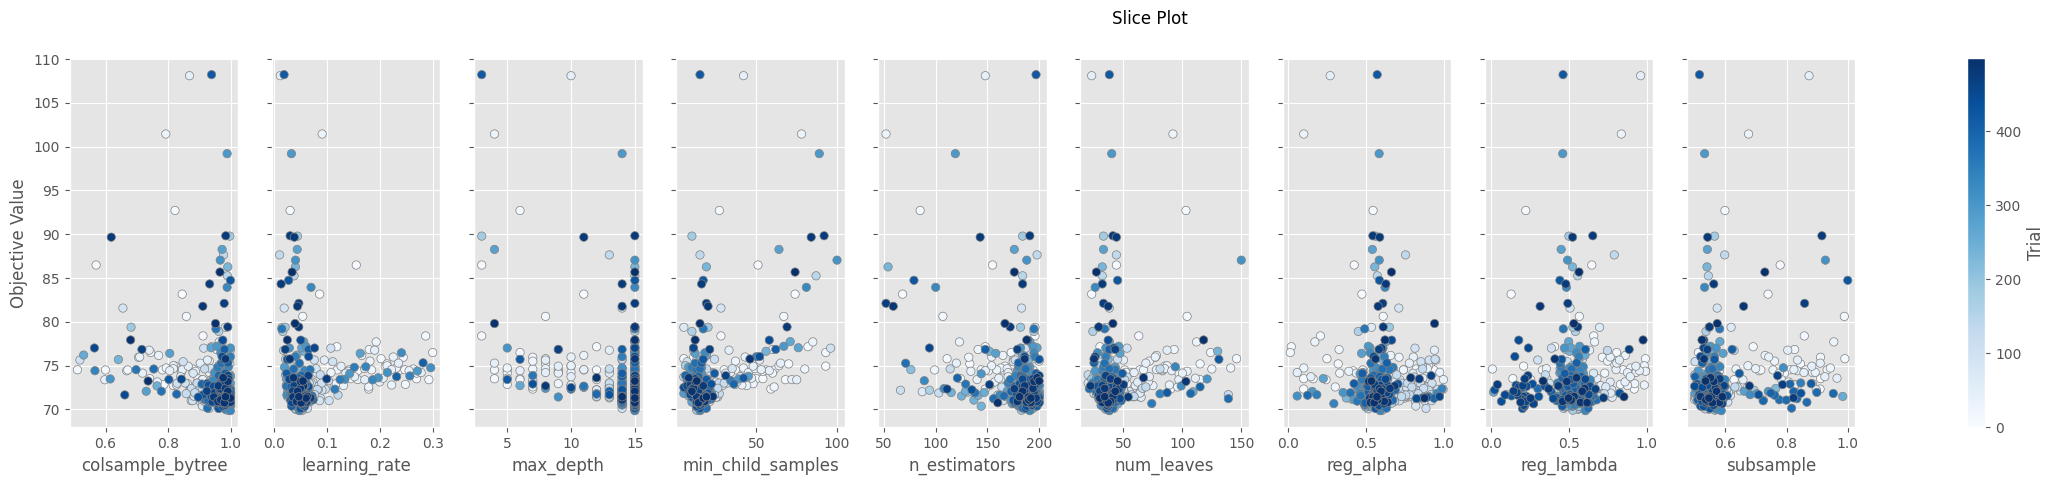

In [10]:
optuna.visualization.matplotlib.plot_slice(study)